# Least_Square_Fit




**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, April 22, 2021 at 10:55 PM.</small></i>

Import the ROOT libraries

In [2]:
import ROOT as R
from math import pow, sqrt
R.gROOT.SetStyle("ATLAS")

Linear least square method

In [9]:
def lls(l_x=[], l_y=[], l_ye=[],):#here 'l' means list!---
  """
  A simple linear regression, y=m*x+b
  """
  sum_1, sum_x, sum_x2 = 0, 0, 0
  sum_xy, sum_y, sum_y2 = 0, 0, 0
  
  for i in range(len(l_x)):
    ye = l_ye[i]
    x = l_x[i]
    y = l_y[i]
    if ye == 0: continue # ignore empty bins
    sum_1 += pow(ye, -2)
    sum_x += x*pow(ye, -2)
    sum_y += y*pow(ye, -2)
    sum_x2 += pow(x/ye, 2)
    sum_xy += x*y*pow(ye, -2)
    sum_y2 += pow(y/ye, 2)

  #From szhang (Jun 6, 2022), the following formulas are from P126, P127 of Louis---
  m = (sum_1 * sum_xy - sum_x * sum_y) / (sum_1 * sum_x2 - pow(sum_x, 2))
  b = (sum_y * sum_x2 - sum_x * sum_xy) / (sum_1 * sum_x2 - pow(sum_x, 2))

  # Error
  #From szhang (Jun 8, 2022), from eq.(5.10) of Louis---
  #(szhang; Jun 8, 2022): n is omitted? Above expression of [f] also omitted n, offset, the followings are correct---
  v_m = sum_1 / (sum_1 * sum_x2 - pow(sum_x, 2))
  v_b = sum_x2 / (sum_1 * sum_x2 - pow(sum_x, 2))
  corr_mb0 = - sum_x / sqrt(sum_1 * sum_x2)#What is mb0????????????????????????????????????

  # Error matrix
  #(szhang; Jun 8, 2022): n is omitted? Above expression of [f] also omitted n, offset, the followings are correct---
  mat = R.TMatrixD(2,2)
  R.TMatrixDRow(mat, 0)[0] = sum_x2
  R.TMatrixDRow(mat, 0)[1] = sum_x
  R.TMatrixDRow(mat, 1)[0] = sum_x
  R.TMatrixDRow(mat, 1)[1] = sum_1
  mat_inv = mat.Invert()
  e_m = sqrt(R.TMatrixDRow(mat_inv, 0)(0)) 
  e_b = sqrt(R.TMatrixDRow(mat_inv, 1)(1)) 
  corr_mb = (R.TMatrixDRow(mat_inv, 0)(1)) / (e_m*e_b)#Whys should we divide by (e_m*e_b)????????????????????????????????? 

  # Chi-square of the fit
  chi2 = 0
  for i in range(len(l_x)):
    ye = l_ye[i]
    x = l_x[i]
    y_obs = l_y[i]
    y_pre = m*x + b
    chi2 += pow( (y_pre - y_obs)/ye, 2)

  print(sqrt(v_m), e_m, sqrt(v_b), e_b, corr_mb0, corr_mb)
  return [m, e_m, b, e_b, corr_mb, chi2]

Input data

In [17]:
l_x, l_y, l_ye=[], [], []
l_x = [0, 1, 2, 3, 4]
l_y = [5., 7., 11., 12., 14.]
l_ye = [0.1, 0.2, 0.1, 0.2, 0.1]
nbins = len(l_x)

In [21]:
#New unit by szhang, Jun 8, 2022---
#to print the result of m b as well as the error---
[est_m, est_err_m, est_b, est_err_b, est_corr_mb, chi2] = lls(l_x, l_y, l_ye)


0.034299717028501764 0.034299717028501764 0.08696565534786725 0.08696565534786725 -0.7888106377466154 -0.7888106377466154


Vanilla least square fit
=================

Fill a histogram

In [12]:
bin0, bin1=-0.5, 4.5

hname = "test_data"
hd = R.TH1F(hname, hname, nbins, bin0, bin1)
hd.Sumw2()
hd.GetXaxis().SetTitle("x")
hd.GetYaxis().SetTitle("y")

for i in range(nbins):
  hd.SetBinContent(i+1, l_y[i])
  hd.SetBinError(i+1, l_ye[i])

Warning in <TROOT::Append>: Replacing existing TH1: test_data (Potential memory leak).


Least square fit

In [13]:
[est_m, est_err_m, est_b, est_err_b, est_corr_mb, chi2] = lls(l_x, l_y, l_ye)
print("\nInput [x]:", l_x)
print("Input [y]:", l_y)
print("Input [y_err]:", l_ye)
print("Estimated m (p1): {0} +/- {1}".format(est_m, est_err_m))
print("Estimated b (p0): {0} +/- {1}".format(est_b, est_err_b))
print("Estimated correlation (m, b): {0}\n\n".format(est_corr_mb))
est_m1 = est_m
est_b1 = est_b

0.034299717028501764 0.034299717028501764 0.08696565534786725 0.08696565534786725 -0.7888106377466154 -0.7888106377466154

Input [x]: [0, 1, 2, 3, 4]
Input [y]: [5.0, 7.0, 11.0, 12.0, 14.0]
Input [y_err]: [0.1, 0.2, 0.1, 0.2, 0.1]
Estimated m (p1): 2.2647058823529407 +/- 0.034299717028501764
Estimated b (p0): 5.399159663865545 +/- 0.08696565534786725
Estimated correlation (m, b): -0.7888106377466154




Goodness of fit
Number of degrees of freedom (dof): # of data points - # of parameters calculated from the data points

In [8]:
ndof = len(l_x)-2
chindodf = 0
if ndof >1: chindodf = chi2 / float(ndof)

P-value

In [9]:
p = R.Math.chisquared_cdf_c(chindodf, 1.)
p2 = R.Math.chisquared_cdf_c(chi2, ndof)
print("Chi2= {0}, n.dof= {1}, p-value= {2}, {3}".format(chi2, ndof, p, p2))

Chi2= 163.65546218487376, n.dof= 3, p-value= 1.5140231137070554e-13, 2.9799092682381677e-35


Plotting

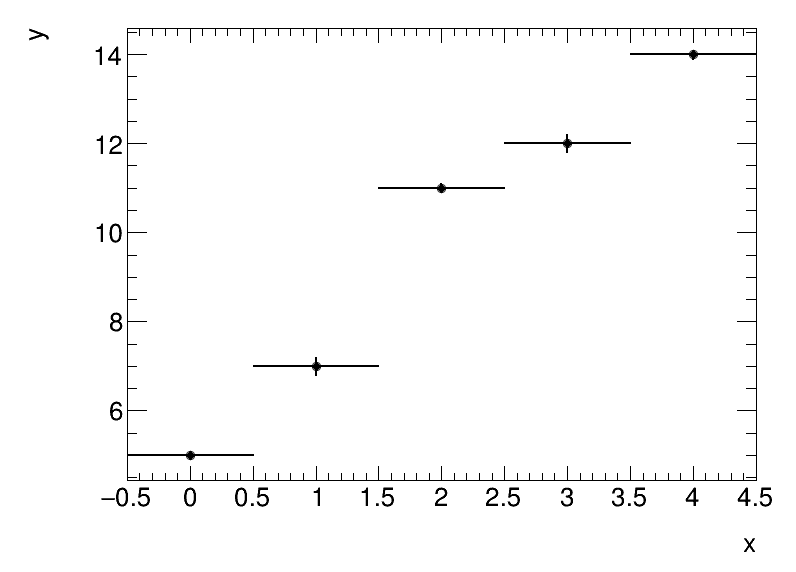

In [10]:
myc = R.TCanvas("c", "c", 800, 600)
myc.SetFillColor(0)

myc.cd()
hd.Draw()
myc.Draw()

Do a fitting. By default ROOT uses Chi-square fit


ROOT TF1 Chi2= 163.65546218487404

****************************************
Minimizer is Linear / Migrad
Chi2                      =      163.655
NDf                       =            3
p0                        =      5.39916   +/-   0.0869657   
p1                        =      2.26471   +/-   0.0342997   

****************************************
Minimizer is Linear / Migrad
Chi2                      =      163.655
NDf                       =            3
p0                        =      5.39916   +/-   0.0869657   
p1                        =      2.26471   +/-   0.0342997   

Covariance Matrix:

            	          p0          p1
p0          	    0.007563  -0.0023529
p1          	  -0.0023529   0.0011765

Correlation Matrix:

            	          p0          p1
p0          	           1    -0.78881
p1          	    -0.78881           1


Info in <TCanvas::Print>: png file exer2_fitting_1.png has been created


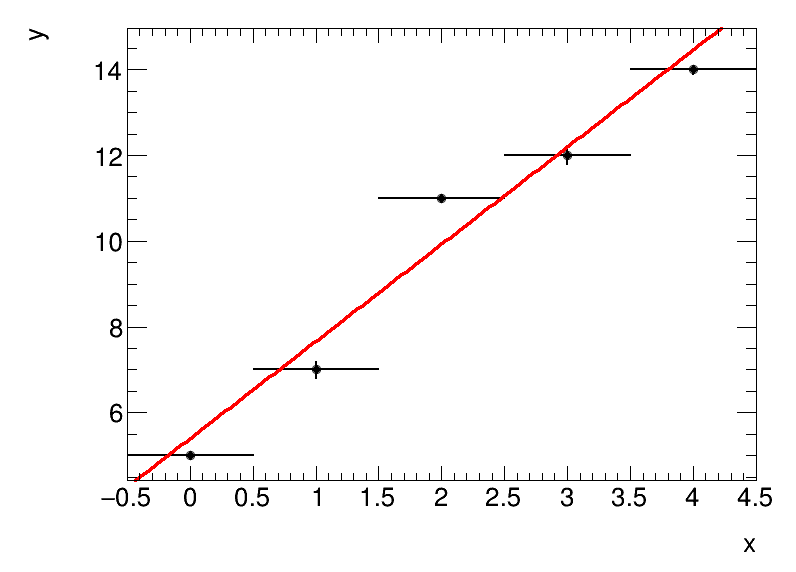

In [11]:
my1 = R.TF1("myFunc1", "pol1", bin0, bin1)
my1.SetLineColor(2)

frp1 = hd.Fit("myFunc1", "S")
frp1.Print("V")

fchi2 = frp1.Chi2()
print("\nROOT TF1 Chi2= {0}".format(fchi2))

myc.Update()
myc.Draw()
myc.SaveAs("exer2_fitting_1.png")

Inflat the measured error by a factor of 10
=================

In [12]:
l_ye_2 = []
for i, e in enumerate(l_ye):
  l_ye_2.append(e*10.)

hname = "test_data_2"
hd2 = R.TH1F(hname, hname, nbins, bin0, bin1)
hd2.Sumw2()
hd2.GetXaxis().SetTitle("x")
hd2.GetYaxis().SetTitle("y")

for i in range(nbins):
  hd2.SetBinContent(i+1, l_y[i])
  hd2.SetBinError(i+1, l_ye_2[i])

Least square fit

In [11]:
[est_m, est_err_m, est_b, est_err_b, est_corr_mb, chi2] = lls(l_x, l_y, l_ye_2)
print("\nInput [x]:", l_x)
print("Input [y]:", l_y)
print("Input [y_err]:", l_ye_2)
print("Estimated m (p1): {0} +/- {1}".format(est_m, est_err_m))
print("Estimated b (p0): {0} +/- {1}".format(est_b, est_err_b))
print("Estimated correlation (m, b): {0}\n\n".format(est_corr_mb))

0.3429971702850177 0.34299717028501775 0.8696565534786727 0.8696565534786728 -0.7888106377466154 -0.7888106377466156

Input [x]: [0, 1, 2, 3, 4]
Input [y]: [5.0, 7.0, 11.0, 12.0, 14.0]
Input [y_err]: [1.0, 2.0, 1.0, 2.0, 1.0]
Estimated m (p1): 2.264705882352941 +/- 0.34299717028501775
Estimated b (p0): 5.399159663865547 +/- 0.8696565534786728
Estimated correlation (m, b): -0.7888106377466156




Goodness of fit
Number of degrees of freedom (dof): # of data points - # of parameters calculated from the data points

In [12]:
ndof = len(l_x)-2
chindodf = 0
if ndof >1: chindodf = chi2 / float(ndof)

P-value

In [13]:
p = R.Math.chisquared_cdf_c(chindodf, 1.)
p2 = R.Math.chisquared_cdf_c(chi2, ndof)
print("Chi2= {0}, n.dof= {1}, p-value= {2}, {3}".format(chi2, ndof, p, p2))

Chi2= 1.6365546218487392, n.dof= 3, p-value= 0.4601547568507153, 0.6511299985105288


Plotting

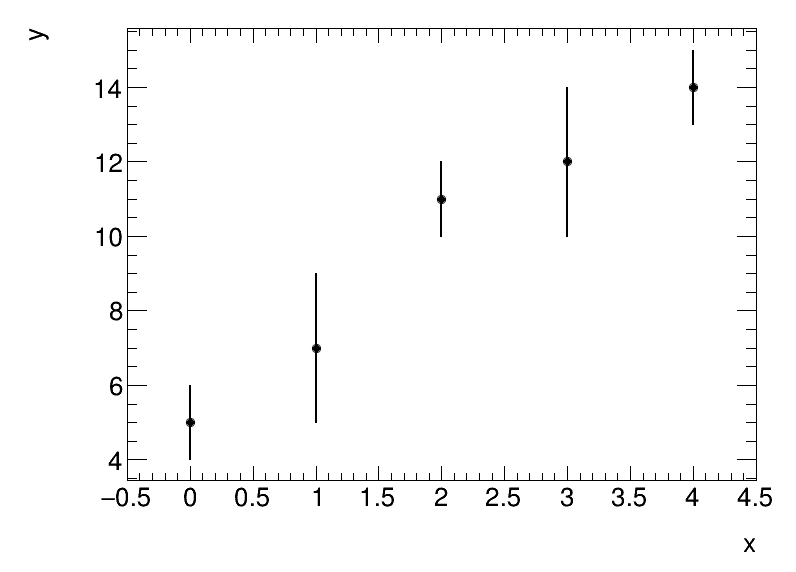

In [14]:
myc.cd()
hd2.Draw()
myc.Draw()

Fitting with ROOT


ROOT TF1 Chi2= 1.6365546218487421

****************************************
Minimizer is Linear / Migrad
Chi2                      =      1.63655
NDf                       =            3
p0                        =      5.39916   +/-   0.869657    
p1                        =      2.26471   +/-   0.342997    

****************************************
Minimizer is Linear / Migrad
Chi2                      =      1.63655
NDf                       =            3
p0                        =      5.39916   +/-   0.869657    
p1                        =      2.26471   +/-   0.342997    

Covariance Matrix:

            	          p0          p1
p0          	      0.7563    -0.23529
p1          	    -0.23529     0.11765

Correlation Matrix:

            	          p0          p1
p0          	           1    -0.78881
p1          	    -0.78881           1


Info in <TCanvas::Print>: png file exer2_fitting_2.png has been created


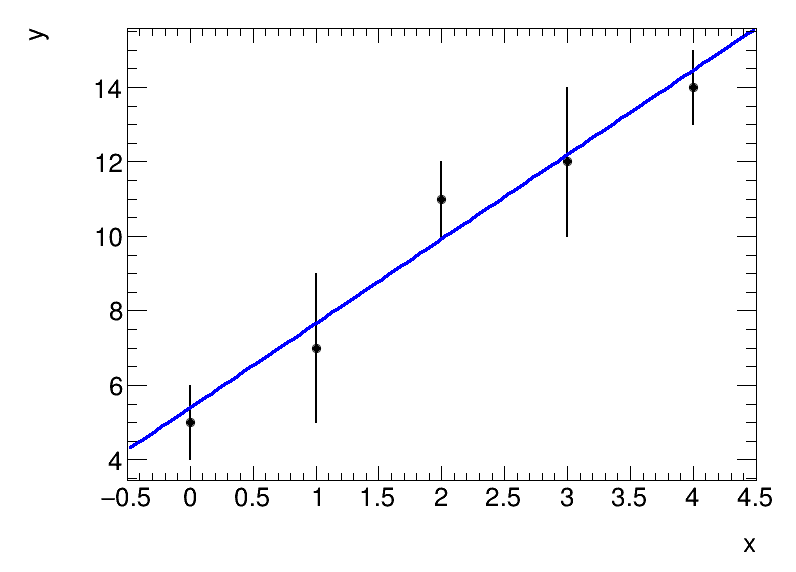

In [15]:
my2 = R.TF1("myFunc2", "pol1", bin0, bin1)
my2.SetLineColor(4)

frp2 = hd2.Fit("myFunc2", "S")
frp2.Print("V")

fchi2 = frp2.Chi2()
print("\nROOT TF1 Chi2= {0}".format(fchi2))

myc.Update()
myc.Draw()
myc.SaveAs("exer2_fitting_2.png")

Use the "deviation from the fit" to quote the errors
=================
You can also consider the method mentioned in the text book (Lyons): Comment (vii), page 132
Note that the code below is something different ...

In [16]:
l_ye_3 = []
for i, e in enumerate(l_ye):
  y_pre = est_m1*l_x[i] + est_b1
  l_ye_3.append(l_y[i] - y_pre)

hname = "test_data_3"
hd3 = R.TH1F(hname, hname, nbins, bin0, bin1)
hd3.Sumw2()
hd3.GetXaxis().SetTitle("x")
hd3.GetYaxis().SetTitle("y")

for i in range(nbins):
  hd3.SetBinContent(i+1, l_y[i])
  hd3.SetBinError(i+1, l_ye_3[i])

Least square fit

In [17]:
[est_m, est_err_m, est_b, est_err_b, est_corr_mb, chi2] = lls(l_x, l_y, l_ye_2)
print("\nInput [x]:", l_x)
print("Input [y]:", l_y)
print("Input [y_err]:", l_ye_3)
print("Estimated m (p1): {0} +/- {1}".format(est_m, est_err_m))
print("Estimated b (p0): {0} +/- {1}".format(est_b, est_err_b))
print("Estimated correlation (m, b): {0}\n\n".format(est_corr_mb))

0.3429971702850177 0.34299717028501775 0.8696565534786727 0.8696565534786728 -0.7888106377466154 -0.7888106377466156

Input [x]: [0, 1, 2, 3, 4]
Input [y]: [5.0, 7.0, 11.0, 12.0, 14.0]
Input [y_err]: [-0.3991596638655448, -0.663865546218485, 1.071428571428573, -0.19327731092436728, -0.4579831932773075]
Estimated m (p1): 2.264705882352941 +/- 0.34299717028501775
Estimated b (p0): 5.399159663865547 +/- 0.8696565534786728
Estimated correlation (m, b): -0.7888106377466156




Goodness of fit
Number of degrees of freedom (dof): # of data points - # of parameters calculated from the data points

In [18]:
ndof = len(l_x)-2
chindodf = 0
if ndof >1: chindodf = chi2 / float(ndof)

P-value

In [19]:
p = R.Math.chisquared_cdf_c(chindodf, 1.)
p2 = R.Math.chisquared_cdf_c(chi2, ndof)
print("Chi2= {0}, n.dof= {1}, p-value= {2}, {3}".format(chi2, ndof, p, p2))

Chi2= 1.6365546218487392, n.dof= 3, p-value= 0.4601547568507153, 0.6511299985105288


Plotting

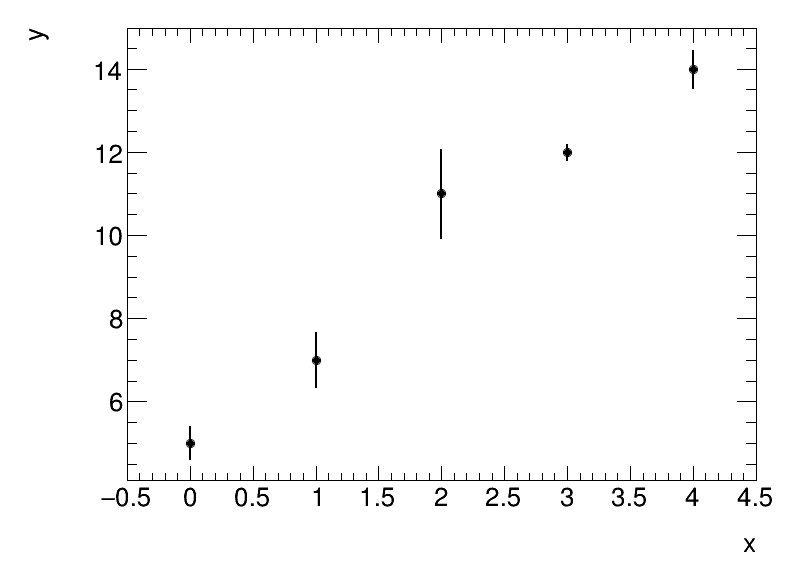

In [20]:
myc.cd()
hd3.Draw()
myc.Draw()

Fitting with ROOT


ROOT TF1 Chi2= 2.2438973155544204

****************************************
Minimizer is Linear / Migrad
Chi2                      =       2.2439
NDf                       =            3
p0                        =      5.04448   +/-   0.356801    
p1                        =      2.30426   +/-   0.127057    

****************************************
Minimizer is Linear / Migrad
Chi2                      =       2.2439
NDf                       =            3
p0                        =      5.04448   +/-   0.356801    
p1                        =      2.30426   +/-   0.127057    

Covariance Matrix:

            	          p0          p1
p0          	     0.12731   -0.040755
p1          	   -0.040755    0.016143

Correlation Matrix:

            	          p0          p1
p0          	           1      -0.899
p1          	      -0.899           1


Info in <TCanvas::Print>: png file exer2_fitting_3.png has been created


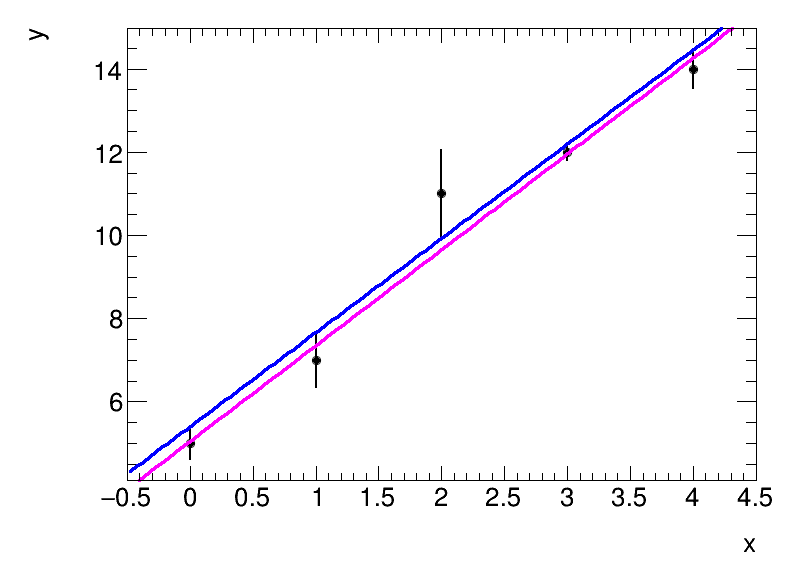

In [21]:
my3 = R.TF1("myFunc3", "pol1", bin0, bin1)
my3.SetLineColor(R.kMagenta)
my2.Draw("same")

frp3 = hd3.Fit("myFunc3", "S")
frp3.Print("V")

fchi2 = frp3.Chi2()
print("\nROOT TF1 Chi2= {0}".format(fchi2))

myc.Update()
myc.Draw()
myc.SaveAs("exer2_fitting_3.png")

Hypo test
===============
How probable is the fit of the line y=2x+5 to the data for the case where the errors are inflated by 10
Chi-square of the fit

In [22]:
chi2 = 0
for i in range(len(l_x)):
  ye = l_ye[i]*10.
  x = l_x[i]
  y_obs = l_y[i]
  y_pre = 2*x + 5
  chi2 += pow( (y_pre - y_obs)/ye, 2)

ndof = len(l_x)
chindodf = 0
if ndof >1: chindodf = chi2 / float(ndof)

P-value

In [23]:
p = R.Math.chisquared_cdf_c(chindodf, 1.)
p2 = R.Math.chisquared_cdf_c(chi2, ndof)
print("Chi2= {0}, n.dof= {1}, p-value= {2}, {3}".format(chi2, ndof, p, p2))

Chi2= 5.25, n.dof= 5, p-value= 0.3055070868612537, 0.3861379243372884


Plotting

In [24]:
my4 = R.TF1("myFunc4", "pol1", bin0, bin1)
my4.SetParameter(0, 5)
my4.SetParameter(1, 2)
my4.SetLineColor(R.kGreen)
chi2_4 = hd2.Chisquare(my4, "R")
print("Chi2= {0}".format(chi2_4))

myc.Update()
my4.Draw("same")
myc.SaveAs("exer2_fitting_4.png")

Chi2= 5.25


Info in <TCanvas::Print>: png file exer2_fitting_4.png has been created


Draw all canvases 

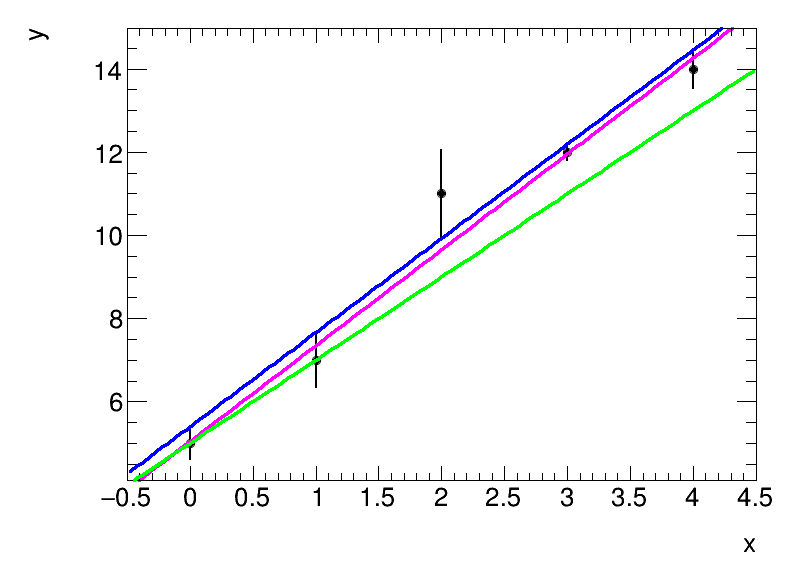

In [25]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()